### Name: Aditya Taori and Gurneet Chhabra
### Course Name: Introduction to Statistical Machine Learning
### Course Code: DSCC465
### Assignment Name: Kaggle Assignment
### Kaggle Team Name: By The Numbers

### Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
import random
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from pandas import Series
from nltk.probability import FreqDist
import math
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import nltk
import emoji
from pandas import Series
from keras.models import Sequential
from keras.layers import Dense,SpatialDropout1D
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import pandas as pd
import random
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.svm import LinearSVC

Using TensorFlow backend.


### Function for creating wordcloud

In [2]:
def text_wc(tweets_col,title):
    tweets_text = " ".join(tweets_col.values.tolist())  #Merging all column text into one 
    
    tweet_wc = WordCloud(background_color="white").generate(tweets_text)  #Wordcloud Object

    plt.imshow(tweet_wc, interpolation='bilinear')  
    plt.axis("off")
    plt.title(title)
    plt.show()
    return plt

### Hyper Parameter tuning for Logistic Regression

In [3]:
def log_reg_hyper_opt(c_val,solver_val,train_X,train_y,test_X,test_y):
    for s in solver_val:
        for c in c_val:
            print(s,"\n")
            print(c,"\n")
            lr_clf = LogisticRegression(solver = s,C = c,penalty = 'l2',random_state = 265)
            lr_model = lr_clf.fit(train_X,train_y)
            lr_predictions = lr_model.predict(test_X)
            lr_accuracy = accuracy_score(test_y,lr_predictions)
            #y_prob = tfidf_vect_lr_model.predict_proba(test_X)[:,1]
            print("\n",classification_report(test_y,lr_predictions))
            print('Confusion Matrix:\n',confusion_matrix(test_y, lr_predictions))
            print(lr_accuracy)

### Function for cleaning tweets

In [4]:
lemmatizer = WordNetLemmatizer()
cachedStopWords = stopwords.words("english")
custom_sw = ["today","thank","thanks","need","small","business","support","help","american","time","day","great","family","community","veteran","year"
             ,"people","new","work","act","job","#veteran","#family","bill","congress","proud","#job","week","continue"
             ,"one","state","#american","must","#job"]
cachedStopWords.extend(custom_sw)
u = string.punctuation.replace("#","")
def clean_tweets(tweets_text,sw_rem):
    
    tweets_text = re.sub("b['\"]","",tweets_text)
    tweets_text = re.sub('http\S+|www\.\S+',"",tweets_text)
    #tweets_text = re.sub('#[A-Za-z0-9]*',"",tweets_text)
    #tweets_text = re.sub('@[A-Za-z0-9]*',"",tweets_text)
    tweets_text = re.sub(r'[\\]n'," ",tweets_text)
    tweets_text = re.sub(r'[\\]x[a-f0-9][a-f0-9]',"",tweets_text)
    tweets_text = re.sub(r'(&amp;)|RT ',"",tweets_text)
    if sw_rem==1:
        regexes= r'\b(' + r'|'.join(cachedStopWords) + r')\b\s*'
        tweets_text = re.sub(regexes,"",tweets_text.lower())
    new_string = tweets_text.translate(str.maketrans('', '', u))
    tokenized_string = new_string.split(" ")
    without_digit = [i for i in tokenized_string if not i.isdigit()]
    no_small_words_text = [i for i in without_digit if len(i)>2]  #Removing short characters
    
    lemmatized_string_list = [lemmatizer.lemmatize(word) for word in no_small_words_text if word!=""]
    if len(lemmatized_string_list)==0:
        lemmatized_string = "ret"
    else:
        lemmatized_string = " ".join(lemmatized_string_list)
    #lemmatized_string = " ".join(no_small_words_text)
    #print(new_string)
    #print("\n")
    return lemmatized_string

### Setting up input directories

In [5]:
input_dir = "E:/UOR Notes/Stats for Machine Learning/Assignments/Kaggle Assignment/"
training_input_file = "congressional_tweet_training_data.csv"
testing_input_file = "congressional_tweet_test_data.csv"
training_input_path = input_dir+training_input_file
testing_input_path = input_dir + testing_input_file
random.seed(265)  #Setting random seed

### Reading CSV files Tweets Data

In [6]:
cong_tweets_data = pd.read_csv(training_input_path)  #Reading input file 
cong_tweets_data.head()  #Printing top 5 rows 

,favorite_count,full_text,hashtags,retweet_count,year,party_id
0,0,"b""RT @KUSINews: One of our longtime viewers wa...",KUSI,10,2017.0,R
1,258,"b""Today I'm urging the @CDCgov to immediately ...",Coronavirus,111,2020.0,R
2,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",MO03,2,2014.0,R
3,9,b'Congrats to #TeamUSA and Canton Native @JGre...,TeamUSA WorldJuniors,3,2017.0,R
4,3,b'Pleased to support @amergateways at their Ju...,ImmigrantHeritageMonth,3,2019.0,D


In [7]:
cong_tweets_data.shape  #Printing Shape of Dataframe

(592803, 6)

In [8]:
cong_tweets_data.isna().sum()  #Checking for NA values in dataframe

favorite_count        0
full_text             0
hashtags              0
retweet_count         0
year              18712
party_id              0
dtype: int64

### Reading CSV files Tweets Data

In [9]:
cong_testing_data = pd.read_csv(testing_input_path)
cong_testing_data.head()

,Id,favorite_count,full_text,hashtags,retweet_count,year,party
0,0,70,b'#TaxReform improved the playing field for Am...,TaxReform,13,2018.0,D
1,1,27,"b'This #NativeWomensEqualPay Day, we recommit ...",NativeWomensEqualPay,11,NaN,D
2,2,49,"b""\xe2\x80\x9cI became convinced that our gene...",MeToo ShatteringTheSilence,24,2017.0,D
3,3,14,"b'During #NationalAdoptionMonth, we honor the ...",NationalAdoptionMonth,2,2019.0,D
4,4,13,b'Happy #AirborneDay to our @USArmy paratroope...,AirborneDay AirborneAllTheWay,7,2018.0,D


In [10]:
cong_testing_data.isna().sum()

Id                   0
favorite_count       0
full_text            0
hashtags             0
retweet_count        0
year              8347
party                0
dtype: int64

In [11]:
#Cleaning Tweets without removing stopwords 
cong_tweets_data["Cleaned_Text_With_Stopwords"] = cong_tweets_data.apply(lambda x:clean_tweets(x['full_text'],0),axis=1)  
cong_tweets_data.head()

,favorite_count,full_text,hashtags,retweet_count,year,party_id,Cleaned_Text_With_Stopwords
0,0,"b""RT @KUSINews: One of our longtime viewers wa...",KUSI,10,2017.0,R,KUSINews One our longtime viewer wa Congressma...
1,258,"b""Today I'm urging the @CDCgov to immediately ...",Coronavirus,111,2020.0,R,Today urging the CDCgov immediately launch pho...
2,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",MO03,2,2014.0,R,Tomorrow #MO03 senior graduate from Calvary Lu...
3,9,b'Congrats to #TeamUSA and Canton Native @JGre...,TeamUSA WorldJuniors,3,2017.0,R,Congrats #TeamUSA and Canton Native JGreenway1...
4,3,b'Pleased to support @amergateways at their Ju...,ImmigrantHeritageMonth,3,2019.0,D,Pleased support amergateways their June Fiesta...


In [12]:
#Cleaning Tweets and removing stopwords
cong_tweets_data["Cleaned_Text_WO_Stopwords"] = cong_tweets_data.apply(lambda x:clean_tweets(x['full_text'],1),axis=1)
cong_tweets_data.head()

,favorite_count,full_text,hashtags,retweet_count,year,party_id,Cleaned_Text_With_Stopwords,Cleaned_Text_WO_Stopwords
0,0,"b""RT @KUSINews: One of our longtime viewers wa...",KUSI,10,2017.0,R,KUSINews One our longtime viewer wa Congressma...,kusinews longtime viewer congressman darrellis...
1,258,"b""Today I'm urging the @CDCgov to immediately ...",Coronavirus,111,2020.0,R,Today urging the CDCgov immediately launch pho...,urging cdcgov immediately launch phone hotline...
2,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",MO03,2,2014.0,R,Tomorrow #MO03 senior graduate from Calvary Lu...,tomorrow #mo03 senior graduate calvary luthera...
3,9,b'Congrats to #TeamUSA and Canton Native @JGre...,TeamUSA WorldJuniors,3,2017.0,R,Congrats #TeamUSA and Canton Native JGreenway1...,congrats #teamusa canton native jgreenway12 wi...
4,3,b'Pleased to support @amergateways at their Ju...,ImmigrantHeritageMonth,3,2019.0,D,Pleased support amergateways their June Fiesta...,pleased amergateways june fiesta honored #immi...


In [13]:
len_tweets = cong_tweets_data["full_text"].apply(len)  #Finding length of Full Text
cong_tweets_data["Tweets_Length"] = len_tweets  

In [14]:
len_clean_tweets = cong_tweets_data["Cleaned_Text_With_Stopwords"].apply(len) #Finding length of cleaned text with Stopwords
cong_tweets_data["Cleaned_Tweets_With_SW_Length"] = len_clean_tweets

In [15]:
len_clean_tweets_wo_sw = cong_tweets_data["Cleaned_Text_WO_Stopwords"].apply(len)  #Finding length of cleaned text without Stopwords
cong_tweets_data["Cleaned_Tweets_WO_Stopwords_Length"] = len_clean_tweets_wo_sw

In [16]:
#finding number of words 
cong_tweets_data["Full_Text_Words"]  = cong_tweets_data["full_text"].apply(lambda x: len(x.split()))
cong_tweets_data["Words_Cleaned_Text_With_Stopwords"]  = cong_tweets_data["Cleaned_Text_With_Stopwords"].apply(lambda x: len(x.split()))
cong_tweets_data["Words_Cleaned_Text_Without_Stopwords"]  = cong_tweets_data["Cleaned_Text_WO_Stopwords"].apply(lambda x: len(x.split()))
cong_tweets_data

,favorite_count,full_text,hashtags,retweet_count,year,party_id,Cleaned_Text_With_Stopwords,Cleaned_Text_WO_Stopwords,Tweets_Length,Cleaned_Tweets_With_SW_Length,Cleaned_Tweets_WO_Stopwords_Length,Full_Text_Words,Words_Cleaned_Text_With_Stopwords,Words_Cleaned_Text_Without_Stopwords
0,0,"b""RT @KUSINews: One of our longtime viewers wa...",KUSI,10,2017.0,R,KUSINews One our longtime viewer wa Congressma...,kusinews longtime viewer congressman darrellis...,154,111,79,24,17,9
1,258,"b""Today I'm urging the @CDCgov to immediately ...",Coronavirus,111,2020.0,R,Today urging the CDCgov immediately launch pho...,urging cdcgov immediately launch phone hotline...,317,239,196,44,34,26
2,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",MO03,2,2014.0,R,Tomorrow #MO03 senior graduate from Calvary Lu...,tomorrow #mo03 senior graduate calvary luthera...,140,110,101,21,16,14
3,9,b'Congrats to #TeamUSA and Canton Native @JGre...,TeamUSA WorldJuniors,3,2017.0,R,Congrats #TeamUSA and Canton Native JGreenway1...,congrats #teamusa canton native jgreenway12 wi...,130,95,87,16,13,11
4,3,b'Pleased to support @amergateways at their Ju...,ImmigrantHeritageMonth,3,2019.0,D,Pleased support amergateways their June Fiesta...,pleased amergateways june fiesta honored #immi...,316,245,204,39,30,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592798,3,"b'This time, it focused on careers in #publics...",publicservice publicsafety,0,2017.0,R,This time focused career #publicservice and #p...,focused career #publicservice #publicsafety,96,57,43,11,7,4
592799,5,"b'.#StormyDaniels, #MichaelWolfe, #JamesComey ...",StormyDaniels MichaelWolfe JamesComey,1,2018.0,R,#StormyDaniels #MichaelWolfe #JamesComey Makin...,#stormydaniels #michaelwolfe #jamescomey makin...,101,67,51,9,8,5
592800,33,b'@NRDems The American people deserve the trut...,CultureOfCorruption,14,2020.0,D,NRDems The American people deserve the truth a...,nrdems deserve truth deserves information requ...,284,221,129,40,33,15
592801,4,b'Only 2 weeks left to submit your #app to the...,app copolitics CAC16 HouseOfCode co06,3,2016.0,R,Only week left submit your #app the Congressio...,week left submit #app congressional app challe...,138,101,87,18,14,11


In [17]:
words_clean_tweets = cong_tweets_data

In [18]:
cong_tweets_data['party_id'].value_counts() #Finding party id distribution

D    324202
R    268601
Name: party_id, dtype: int64

C:\Users\DELL\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


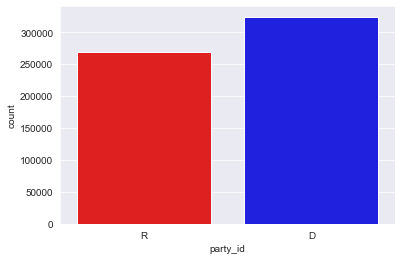

In [19]:
sns.set_style("darkgrid")
sns.countplot(cong_tweets_data['party_id'],palette= ['red',"blue"])  #Plotting Party ID distribution
plt.show()

### Extracting most used hashtags for each party : Demcoratic & Republican

In [20]:
hashtags_list_rep = [] 
hashtags_list_dem = []

In [21]:
cong_tweets_data= cong_tweets_data.reset_index(drop=True)  
for n in range(len(cong_tweets_data['hashtags'])):
    #print(n)
    if cong_tweets_data['party_id'][n]=='R': 
        hashtags_list_rep.append(cong_tweets_data['hashtags'][n])  #Adding Republican Hashtags to the list 
    else:
        hashtags_list_dem.append(cong_tweets_data['hashtags'][n])  #Adding Democratican Hashtags to the list

Text(0.5, 1.0, "Democrats' 10 most used hashtags")

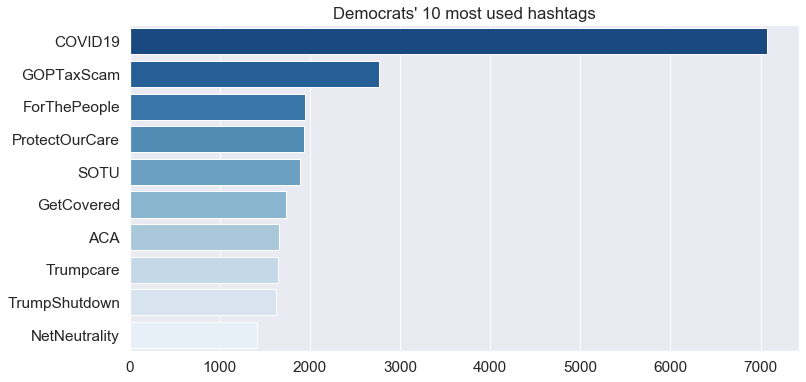

In [22]:
#Plotting top 10 Hashtags used by Democrats 
top_hashtags_dem = Series(hashtags_list_dem).value_counts().head(n=10)  #Counting unique hashtags and fetching top 10
sns.set_style("white")
sns.set(font_scale=1.4)
plt.figure(figsize=(12,6))
sns.barplot(x=top_hashtags_dem, y=top_hashtags_dem.index,  orient='h', palette="Blues_r").set_title("Democrats' 10 most used hashtags")

Text(0.5, 1.0, "Republicans' 10 most used hashtags")

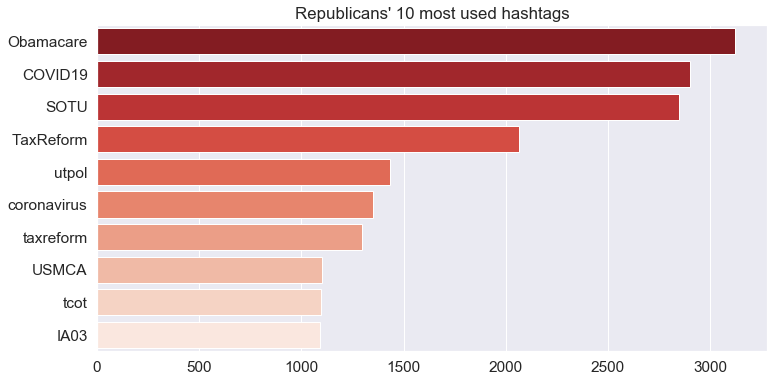

In [23]:
#Plotting top 10 Hashtags used by Republican
top_hashtags_rep = Series(hashtags_list_rep).value_counts().head(n=10) #Counting unique hashtags and fetching top 10
sns.set_style("white")
sns.set(font_scale=1.4)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_hashtags_rep, y=top_hashtags_rep.index, orient='h', palette="Reds_r").set_title("Republicans' 10 most used hashtags")

### Subsetting the data into different parties

In [24]:
republic_tweets_df = cong_tweets_data[cong_tweets_data["party_id"]=="R"]  
democratic_tweets_df = cong_tweets_data[cong_tweets_data["party_id"]=="D"]
print("Republic Tweets Shape",republic_tweets_df.shape)
print("Democratic Tweets Shape",democratic_tweets_df.shape)

Republic Tweets Shape (268601, 14)
Democratic Tweets Shape (324202, 14)


### Combining all the tweets together for the parties

In [25]:
democrat_tweets=" ".join(democratic_tweets_df["Cleaned_Text_WO_Stopwords"].values.tolist()).split(" ")
republican_tweets=" ".join(republic_tweets_df["Cleaned_Text_WO_Stopwords"].values.tolist()).split(" ")

In [26]:
print("Democrat tweets word length:",len(democrat_tweets))
print("Republican tweets word length:",len(republican_tweets))

Democrat tweets word length: 4499945
Republican tweets word length: 3179189


### Frequency of Usage of Words by Parties

In [27]:
#FreqDist records the number of times each words are used. 
fdist_democrat = FreqDist(democrat_tweets)
fdist_republican=FreqDist(republican_tweets)

In [28]:
print("Frequency of Words : Democrat")
fdist_democrat

Frequency of Words : Democrat


FreqDist({'health': 22161, 'american': 19673, 'woman': 17791, 'family': 17749, 'care': 16618, 'right': 16111, 'make': 16095, 'trump': 15530, 'house': 14736, 'country': 12812, ...})

In [29]:
print("Frequency of Words : Republican")
fdist_republican

Frequency of Words : Republican


FreqDist({'house': 12357, 'tax': 8346, 'president': 8090, 'american': 8076, 'see': 7854, 'life': 7548, 'happy': 7462, 'job': 7348, 'watch': 7140, 'family': 7051, ...})

In [30]:
Dem_freqw=Series(fdist_democrat).sort_values(ascending=False).head(15)
Rep_freqw=Series(fdist_republican).sort_values(ascending=False).head(15)

Text(0.5, 1.0, "Democrats' 15 most used words")

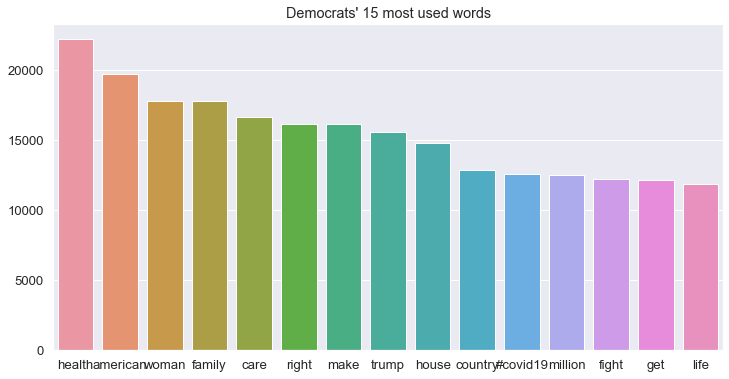

In [31]:
sns.set_style("white")
sns.set(font_scale=1.2)
plt.figure(figsize=(12,6))
sns.barplot(x=Dem_freqw.index, y=Dem_freqw).set_title("Democrats' 15 most used words")

Text(0.5, 1.0, "Republicans' 15 most used words")

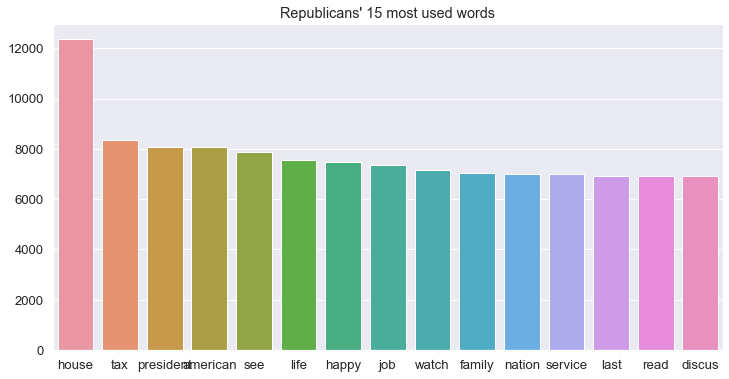

In [32]:
sns.set_style("white")
sns.set(font_scale=1.2)
plt.figure(figsize=(12,6))
sns.barplot(x=Rep_freqw.index, y=Rep_freqw).set_title("Republicans' 15 most used words")

### Creating wordcloud for full original data

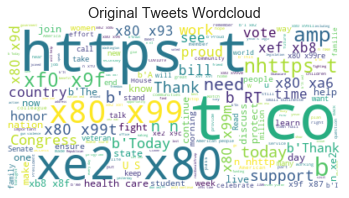

<module 'matplotlib.pyplot' from 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [33]:
text_wc(cong_tweets_data["full_text"],"Original Tweets Wordcloud")

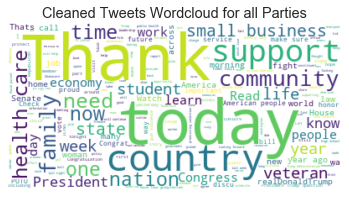

<module 'matplotlib.pyplot' from 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [34]:
text_wc(cong_tweets_data["Cleaned_Text_With_Stopwords"],"Cleaned Tweets Wordcloud for all Parties")

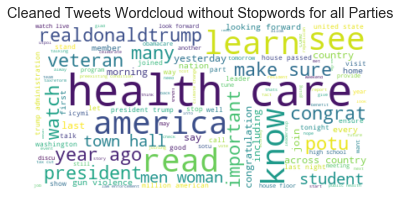

<module 'matplotlib.pyplot' from 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [35]:
text_wc(cong_tweets_data["Cleaned_Text_WO_Stopwords"],"Cleaned Tweets Wordcloud without Stopwords for all Parties")

In [36]:
custom_sw = ["today","thank","need","small","business"]

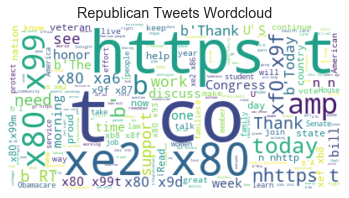

<module 'matplotlib.pyplot' from 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [37]:
text_wc(republic_tweets_df["full_text"],"Republican Tweets Wordcloud")

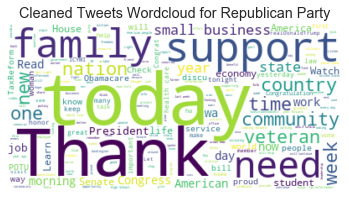

<module 'matplotlib.pyplot' from 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [38]:
text_wc(republic_tweets_df["Cleaned_Text_With_Stopwords"],"Cleaned Tweets Wordcloud for Republican Party")

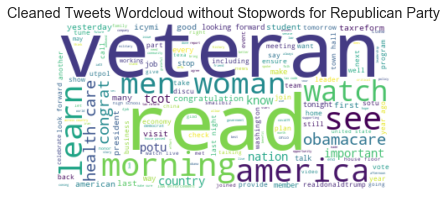

<module 'matplotlib.pyplot' from 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [39]:
text_wc(republic_tweets_df["Cleaned_Text_WO_Stopwords"],"Cleaned Tweets Wordcloud without Stopwords for Republican Party")

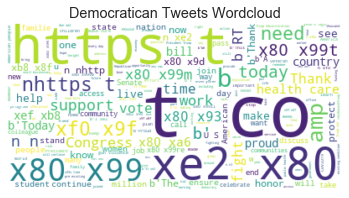

<module 'matplotlib.pyplot' from 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [40]:
text_wc(democratic_tweets_df["full_text"],"Democratican Tweets Wordcloud")

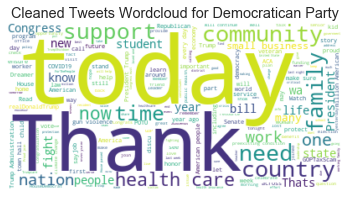

<module 'matplotlib.pyplot' from 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [41]:
text_wc(democratic_tweets_df["Cleaned_Text_With_Stopwords"],"Cleaned Tweets Wordcloud for Democratican Party")

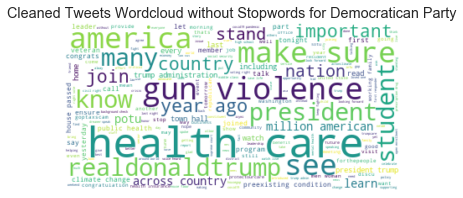

<module 'matplotlib.pyplot' from 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [42]:
text_wc(democratic_tweets_df["Cleaned_Text_WO_Stopwords"],"Cleaned Tweets Wordcloud without Stopwords for Democratican Party")

C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and wil

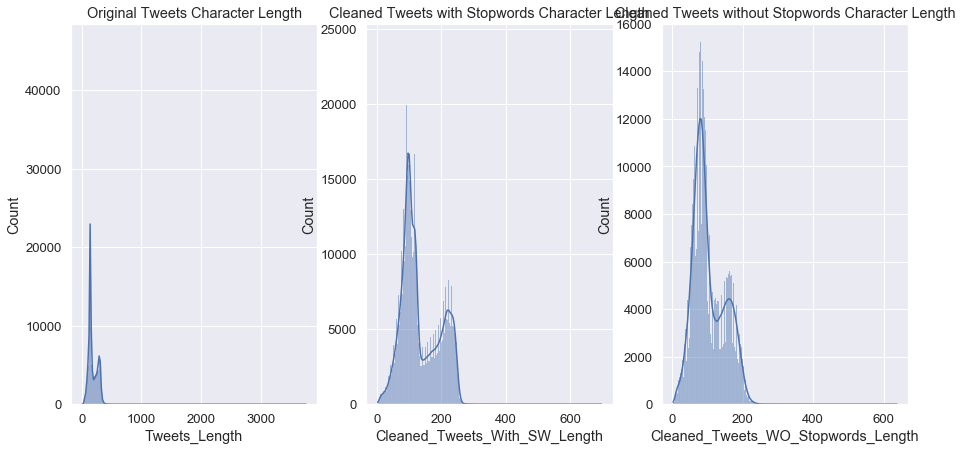

In [43]:

fig, axs = plt.subplots(1, 3,figsize=(15,7))

sns.histplot(ax = axs[0],data=cong_tweets_data, x="Tweets_Length", kde=True)
axs[0].set_title("Original Tweets Character Length")
sns.histplot(ax = axs[1],data=cong_tweets_data, x="Cleaned_Tweets_With_SW_Length", kde=True)
axs[1].set_title("Cleaned Tweets with Stopwords Character Length")
sns.histplot(ax = axs[2],data=cong_tweets_data, x="Cleaned_Tweets_WO_Stopwords_Length", kde=True)
axs[2].set_title("Cleaned Tweets without Stopwords Character Length")
plt.show()

C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and wil

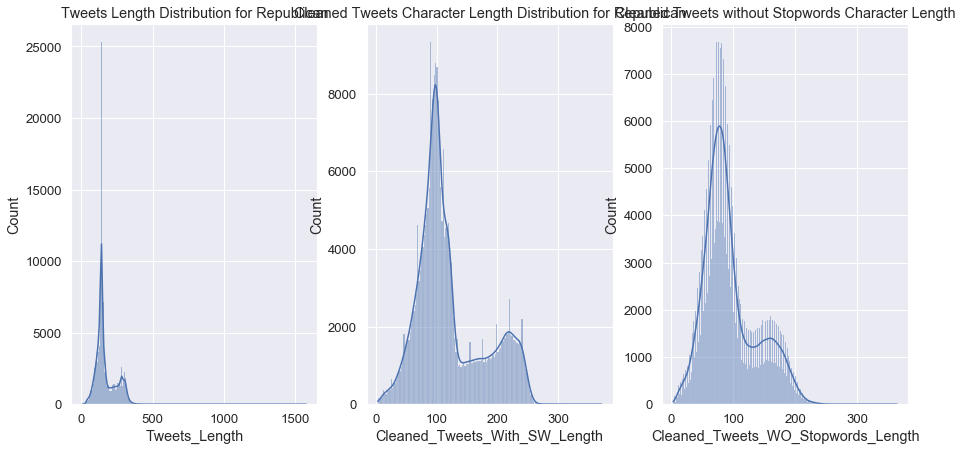

In [44]:

fig, axs = plt.subplots(1, 3,figsize=(15,7))

sns.histplot(ax = axs[0],data=republic_tweets_df, x="Tweets_Length", kde=True)
axs[0].set_title("Tweets Length Distribution for Republican")
sns.histplot(ax = axs[1],data=republic_tweets_df, x="Cleaned_Tweets_With_SW_Length", kde=True)
axs[1].set_title("Cleaned Tweets Character Length Distribution for Republican")
sns.histplot(ax = axs[2],data=republic_tweets_df, x="Cleaned_Tweets_WO_Stopwords_Length", kde=True)
axs[2].set_title("Cleaned Tweets without Stopwords Character Length")
plt.show()

C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and wil

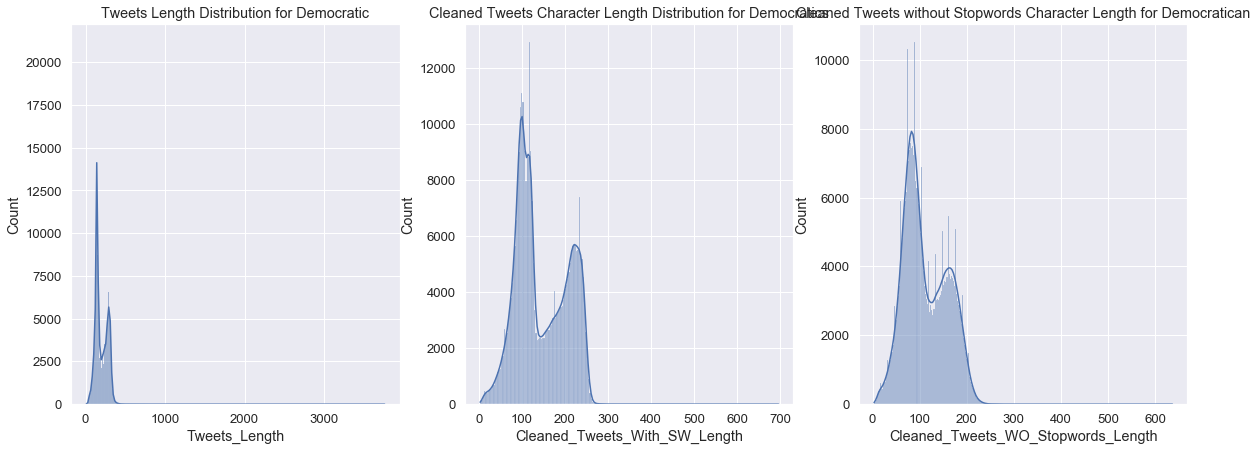

In [45]:

fig, axs = plt.subplots(1, 3,figsize=(20,7))

sns.histplot(ax = axs[0],data=democratic_tweets_df, x="Tweets_Length", kde=True)
axs[0].set_title("Tweets Length Distribution for Democratic")
sns.histplot(ax = axs[1],data=democratic_tweets_df, x="Cleaned_Tweets_With_SW_Length", kde=True)
axs[1].set_title("Cleaned Tweets Character Length Distribution for Democratics")
sns.histplot(ax = axs[2],data=democratic_tweets_df, x="Cleaned_Tweets_WO_Stopwords_Length", kde=True)
axs[2].set_title("Cleaned Tweets without Stopwords Character Length for Democratican")
plt.show()

C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and wil

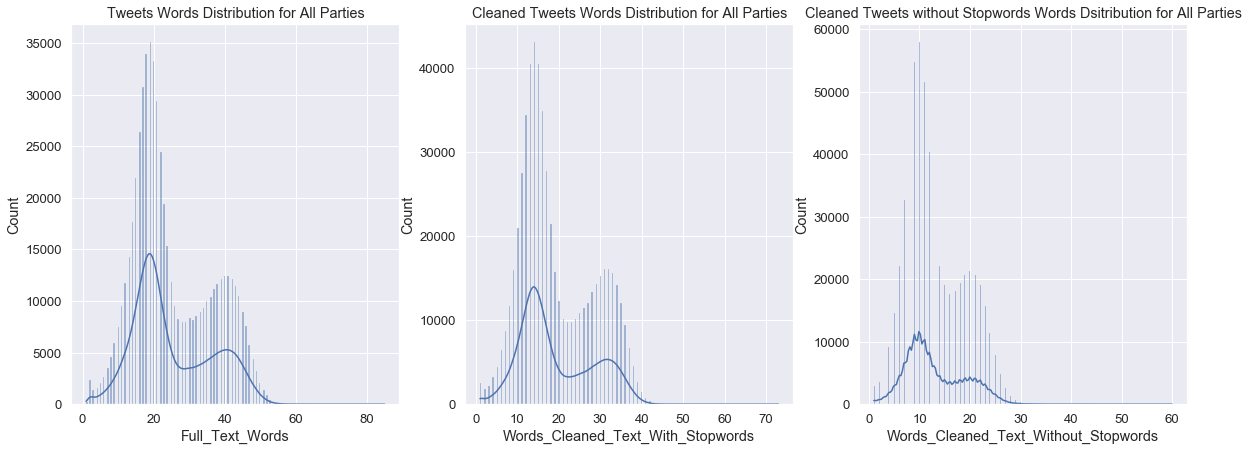

In [46]:

fig, axs = plt.subplots(1, 3,figsize=(20,7))

sns.histplot(ax = axs[0],data=cong_tweets_data, x="Full_Text_Words", kde=True)
axs[0].set_title("Tweets Words Distribution for All Parties")
sns.histplot(ax = axs[1],data=cong_tweets_data, x="Words_Cleaned_Text_With_Stopwords", kde=True)
axs[1].set_title("Cleaned Tweets Words Distribution for All Parties")
sns.histplot(ax = axs[2],data=cong_tweets_data, x="Words_Cleaned_Text_Without_Stopwords", kde=True)
axs[2].set_title("Cleaned Tweets without Stopwords Words Dsitribution for All Parties")
plt.show()

C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and wil

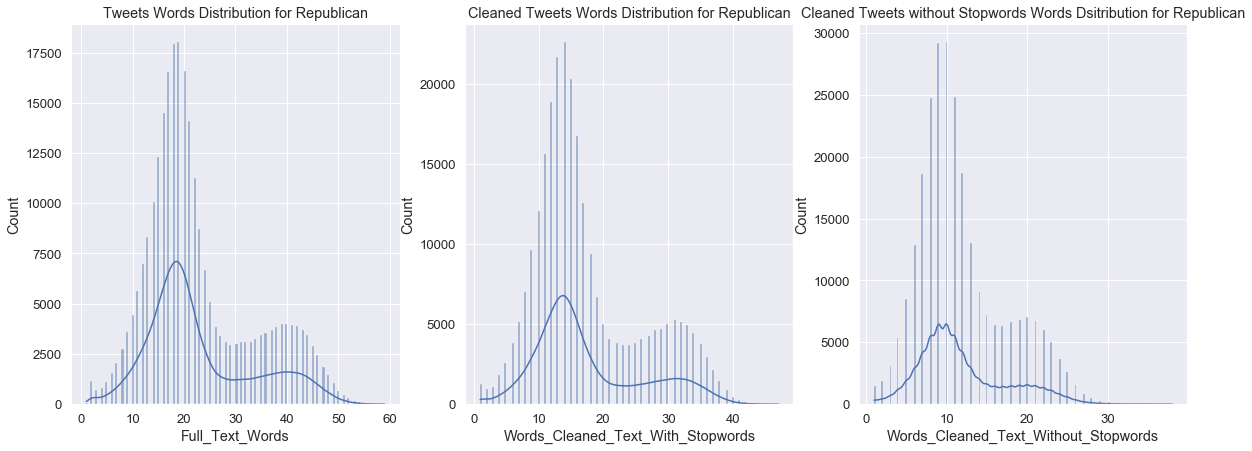

In [47]:

fig, axs = plt.subplots(1, 3,figsize=(20,7))

sns.histplot(ax = axs[0],data=republic_tweets_df, x="Full_Text_Words", kde=True)
axs[0].set_title("Tweets Words Distribution for Republican")
sns.histplot(ax = axs[1],data=republic_tweets_df, x="Words_Cleaned_Text_With_Stopwords", kde=True)
axs[1].set_title("Cleaned Tweets Words Distribution for Republican")
sns.histplot(ax = axs[2],data=republic_tweets_df, x="Words_Cleaned_Text_Without_Stopwords", kde=True)
axs[2].set_title("Cleaned Tweets without Stopwords Words Dsitribution for Republican")
plt.show()

C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and wil

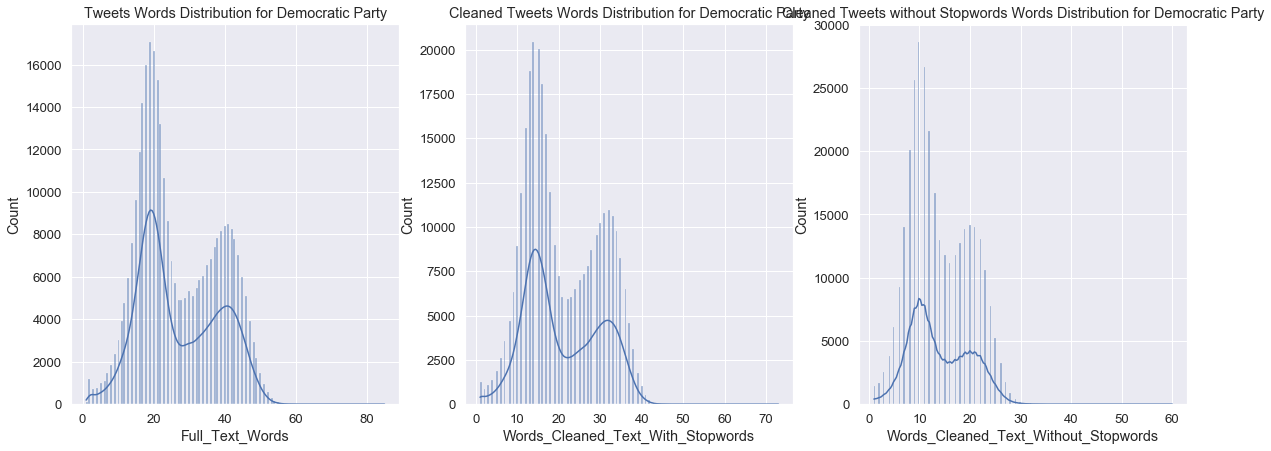

In [48]:

fig, axs = plt.subplots(1, 3,figsize=(20,7))

sns.histplot(ax = axs[0],data=democratic_tweets_df, x="Full_Text_Words", kde=True)
axs[0].set_title("Tweets Words Distribution for Democratic Party")
sns.histplot(ax = axs[1],data=democratic_tweets_df, x="Words_Cleaned_Text_With_Stopwords", kde=True)
axs[1].set_title("Cleaned Tweets Words Distribution for Democratic Party")
sns.histplot(ax = axs[2],data=democratic_tweets_df, x="Words_Cleaned_Text_Without_Stopwords", kde=True)
axs[2].set_title("Cleaned Tweets without Stopwords Words Distribution for Democratic Party")
plt.show()

### Temporal Analysis of Tweets

Text(0.5, 1.0, 'Tweets Distribution Year Wise for all parties')

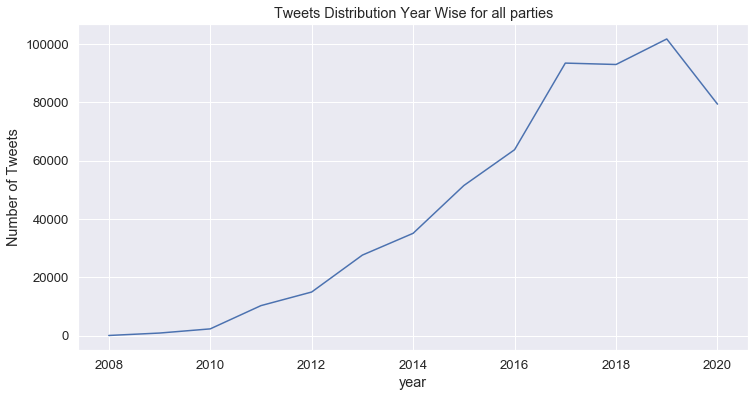

In [49]:
sns.set(font_scale=1.2)
plt.figure(figsize=(12,6))
year_tweets = cong_tweets_data.groupby('year').count()
year_tweets.reset_index(inplace=True)
sns.lineplot(x='year', y='retweet_count', data=year_tweets);
plt.xlabel("year")
plt.ylabel("Number of Tweets")
plt.title("Tweets Distribution Year Wise for all parties")

Text(0.5, 1.0, 'Tweets Distribution Year Wise for Republic Party')

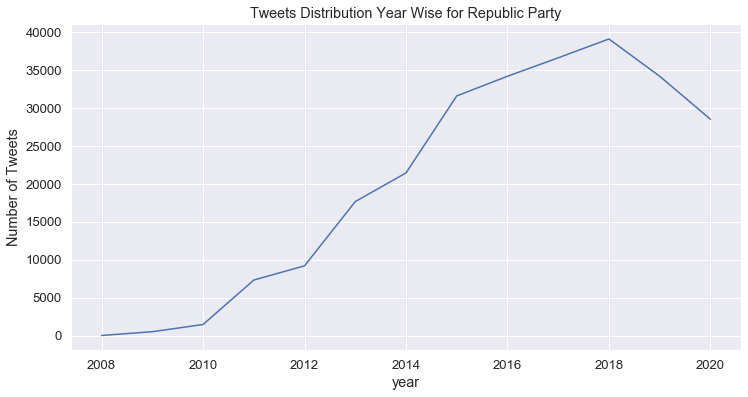

In [50]:
sns.set(font_scale=1.2)
plt.figure(figsize=(12,6))
rep_year_tweets = republic_tweets_df.groupby('year').count()
rep_year_tweets.reset_index(inplace=True)
sns.lineplot(x='year', y='retweet_count', data=rep_year_tweets);
plt.xlabel("year")
plt.ylabel("Number of Tweets")
plt.title("Tweets Distribution Year Wise for Republic Party")

Text(0.5, 1.0, 'Tweets Distribution Year Wise for Democratic Party')

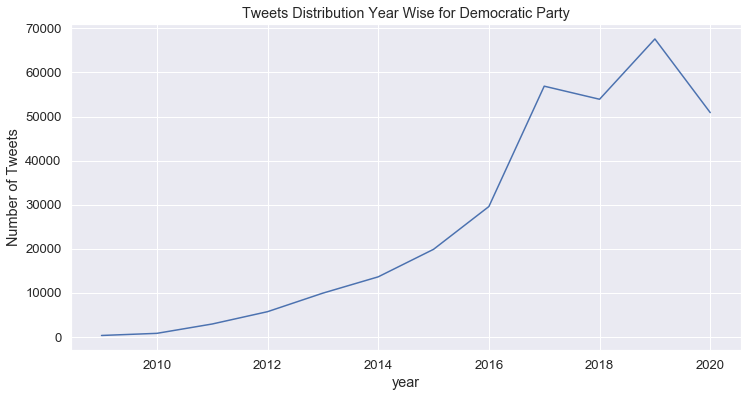

In [51]:
sns.set(font_scale=1.2)
plt.figure(figsize=(12,6))
dem_year_tweets = democratic_tweets_df.groupby('year').count()
dem_year_tweets.reset_index(inplace=True)
sns.lineplot(x='year', y='retweet_count', data=dem_year_tweets);
plt.xlabel("year")
plt.ylabel("Number of Tweets")
plt.title("Tweets Distribution Year Wise for Democratic Party")

In [52]:
years = list(cong_tweets_data["year"].dropna().unique())
years.sort()
print(years)
num_years = len(years)

[2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0]


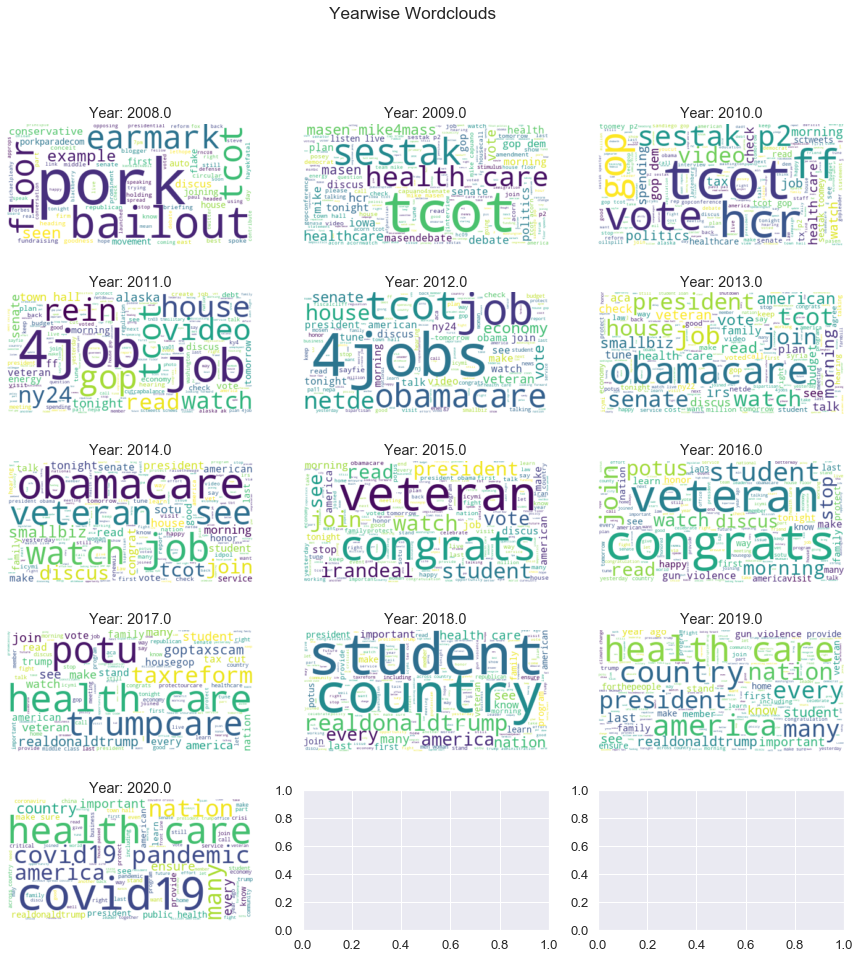

In [53]:
frows = math.ceil(num_years/3)
fig, axs = plt.subplots(frows, 3,figsize=(15,15))
fig.suptitle("Yearwise Wordclouds")
ctr_index = 0
for i in range(frows):
    for j in range(3):
        if ctr_index<num_years:
            year_val= years[ctr_index]
            year_tweets = cong_tweets_data[cong_tweets_data["year"]==year_val]
            tweets_text = " ".join(year_tweets["Cleaned_Text_WO_Stopwords"].values.tolist())  #Converting the column text t 

            tweet_wc = WordCloud(background_color="white").generate(tweets_text)  #Wordcloud Object
            title = "Year: "+str(year_val)
            axs[i,j].imshow(tweet_wc, interpolation='bilinear')  
            axs[i,j].axis("off")
            axs[i,j].set_title(title)
            ctr_index = ctr_index+1
        else:
            break
plt.show()

## Model Building

In [54]:
original_data = cong_tweets_data.copy()
#cong_tweets_data = cong_tweets_data[(cong_tweets_data["Words_Cleaned_Text_Without_Stopwords"] <32)] 

In [55]:
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
cong_tweets_data['encoded_party']= label_encoder.fit_transform(cong_tweets_data["party_id"])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(cong_tweets_data["Cleaned_Text_WO_Stopwords"],cong_tweets_data["encoded_party"],test_size=0.2,shuffle=True)

In [57]:
tfidf_vectorizer12 = TfidfVectorizer(lowercase=True, ngram_range=(1, 2)) #object for ngram_range(1,1)
X_train_vectors_tfidf_12 = tfidf_vectorizer12.fit_transform(X_train) 
X_test_vectors_tfidf_12 = tfidf_vectorizer12.transform(X_test)
print(X_train_vectors_tfidf_12.shape)
print(X_test_vectors_tfidf_12.shape)

(474242, 2872005)
(118561, 2872005)


### Naive Bayes Model

In [58]:
nb_clf = MultinomialNB()
tfidf_vect_nb_model = nb_clf.fit(X_train_vectors_tfidf_12,y_train)
tfidf_vect_nb_predictions = tfidf_vect_nb_model.predict(X_test_vectors_tfidf_12)
tfidf_vect1_accuracy = accuracy_score(y_test,tfidf_vect_nb_predictions)
#y_prob = tfidf_vect_nb_model.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,tfidf_vect_nb_predictions))
print('Confusion Matrix:',confusion_matrix(y_test, tfidf_vect_nb_predictions))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87     65076
           1       0.90      0.75      0.82     53485

    accuracy                           0.85    118561
   macro avg       0.86      0.84      0.84    118561
weighted avg       0.86      0.85      0.85    118561

Confusion Matrix: [[60704  4372]
 [13493 39992]]


### Logistic Regression 

In [59]:
#print(s,"\n")
#print(c,"\n")
lr_clf = LogisticRegression(solver = "liblinear",C = 20,penalty = 'l2')
tfidf_vect_lr_model = lr_clf.fit(X_train_vectors_tfidf_12,y_train)
tfidf_vect_lr_predictions = tfidf_vect_lr_model.predict(X_test_vectors_tfidf_12)
tfidf_vect_lr_accuracy = accuracy_score(y_test,tfidf_vect_lr_predictions)
y_prob = tfidf_vect_lr_model.predict_proba(X_test_vectors_tfidf_12)[:,1]
print("\n",classification_report(y_test,tfidf_vect_lr_predictions))
print('Confusion Matrix:\n',confusion_matrix(y_test, tfidf_vect_lr_predictions))


               precision    recall  f1-score   support

           0       0.89      0.90      0.90     65076
           1       0.88      0.87      0.87     53485

    accuracy                           0.89    118561
   macro avg       0.88      0.88      0.88    118561
weighted avg       0.89      0.89      0.89    118561

Confusion Matrix:
 [[58620  6456]
 [ 7129 46356]]


### SVM with Linear Kernel

In [60]:
svc_clf = LinearSVC(random_state=265)
tfidf_vect_svc_model = svc_clf.fit(X_train_vectors_tfidf_12,y_train)
tfidf_vect_svc_predictions = tfidf_vect_svc_model.predict(X_test_vectors_tfidf_12)
tfidf_vect_svc_accuracy = accuracy_score(y_test,tfidf_vect_svc_predictions)
#y_prob = tfidf_vect_lr_model.predict_proba(X_test_vectors_tfidf)[:,1]
print("\n",classification_report(y_test,tfidf_vect_svc_predictions))
print('Confusion Matrix:\n',confusion_matrix(y_test, tfidf_vect_svc_predictions))


               precision    recall  f1-score   support

           0       0.89      0.90      0.90     65076
           1       0.88      0.87      0.87     53485

    accuracy                           0.89    118561
   macro avg       0.89      0.89      0.89    118561
weighted avg       0.89      0.89      0.89    118561

Confusion Matrix:
 [[58663  6413]
 [ 6929 46556]]


### Random Forest Model

In [61]:
rf_clf_12 = RandomForestClassifier(n_estimators = 10, random_state = 42,max_depth = 10,class_weight = "balanced")
tfidf12_vect_rf_model = rf_clf_12.fit(X_train_vectors_tfidf_12,y_train)
tfidf12_vect_rf_predictions = tfidf12_vect_rf_model.predict(X_test_vectors_tfidf_12)
#tfidf12_vect_rf_accuracy = accuracy_score(y_test,tfidf_vect_rf_predictions)
#y_prob = tfidf_vect_rf_model.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,tfidf12_vect_rf_predictions))
print('Confusion Matrix:',confusion_matrix(y_test, tfidf12_vect_rf_predictions))

              precision    recall  f1-score   support

           0       0.74      0.17      0.27     65076
           1       0.48      0.93      0.63     53485

    accuracy                           0.51    118561
   macro avg       0.61      0.55      0.45    118561
weighted avg       0.62      0.51      0.44    118561

Confusion Matrix: [[10930 54146]
 [ 3750 49735]]


## Topic Modelling Using LDA

In [ ]:
cong_tweets_data['Cleaned_Text_WO_Stopwords'].dropna(inplace=True)
docs = np.array(cong_tweets_data['Cleaned_Text_WO_Stopwords'])
docs = [doc for doc in docs if str(doc) != 'nan']

In [ ]:
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    print(len(docs))
    for idx in range(len(docs)):
        #print(idx)
        #print(docs[idx])
                #docs[idx] = [[word.lower() for word in docs[idx].split()] for line in data] # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
        #print(docs[idx])
            # Remove numbers, but not words that contain numbers.
    docs_token = [[token.lower() for token in doc if not token.isdigit()] for doc in docs]

            # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]

            # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

    return docs

In [ ]:
docs = docs_preprocessor(docs)

In [ ]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

In [ ]:
import time
# Set training parameters.
num_topics = range(5,6)
chunksize = 100 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

for num in num_topics:
    print(num)
    # Make a index to word dictionary.
    if len(dictionary)>0:
        temp = dictionary[0]  # This is only to "load" the dictionary.
        start = time.time()
        id2word = dictionary.id2token
        model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize,alpha='auto', eta='auto', iterations=iterations, num_topics=num,passes=passes, eval_every=eval_every)
        end = time.time()
        print(end-start)
        time_taken = end-start

        Y = model.print_topics(num_words = 10)
        topic_words_list = []
        for i in range(0,len(Y)):
            topic_words_list.append("Topic "+str(i+1)+": ")
            X = Y[i][1]
            a = X.split("+")
            words_str = ""
            for j in range(0,len(a)):
                p = a[j].split("*")[1].replace("\"","")
                words_str += p
            topic_words_list.append(words_str)

        perplexity = model.log_perplexity(corpus)
        coherence_model_lda = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()


In [ ]:
topic_words_list

## LSTM Implementation 

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 40000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 70
# This is fixed.
EMBEDDING_DIM = 500
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [ ]:
X = tokenizer.texts_to_sequences(X_train.values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

In [ ]:
Y = y_train.values
print('Shape of label tensor:', Y.shape)
Y = Y.reshape(-1,1)

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 2
batch_size = 64

history = model.fit(X, Y, epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


In [ ]:
cong_testing_data["Cleaned_Text_WO_Stopwords"] = cong_testing_data.apply(lambda x:clean_tweets(x['full_text'],1),axis=1)
cong_testing_data

In [ ]:
test_data = tfidf_vectorizer12.transform(cong_testing_data["Cleaned_Text_WO_Stopwords"])
print(test_data.shape)

In [ ]:
test_pedictions = svc_clf.predict(test_data)
prediction_labels = label_encoder.inverse_transform(test_pedictions)

In [ ]:
submissions_df = pd.DataFrame()
submissions_df["Id"] = cong_testing_data["Id"]
submissions_df["party"] = prediction_labels
submissions_df.to_csv("sample_submission_v1.csv",index=False)